# IS-BQPhy-Optimization-Proj-F25 Notebook

In [351]:
from typing import List, Tuple

import numpy as np
import bqphy.BQPhy_Optimiser as qea

In [352]:
# ------------------------ PROBLEM-SPECIFIC: Portfolio Data ------------------------ #
# --- REAL DATA (PROBLEM-SPECIFIC) ---

# Data is taken from: https://etfdb.com/compare/market-cap/#:~:text=VOO%20%2079%24823%2C286%2C000,00%2016%2C286%2C791

# Expected returns per $1 invested (decimal)
arrExpectedReturns = np.array([
    0.09, 0.09, 0.09, 0.09, 0.11, 0.10, 0.07, 0.06, 0.08, 0.05,
    0.04, 0.05, 0.10, 0.09, 0.08, 0.12, 0.09, 0.08, 0.08, 0.09,
    0.12, 0.09, 0.10, 0.09, 0.10
], dtype=float)

# Standard deviations (volatility) per asset (PROBLEM-SPECIFIC)
arrVolatilities = np.array([
    0.15, 0.15, 0.15, 0.16, 0.20, 0.18, 0.16, 0.16, 0.14, 0.05,
    0.15, 0.05, 0.18, 0.22, 0.18, 0.21, 0.22, 0.18, 0.11, 0.15,
    0.21, 0.18, 0.22, 0.16, 0.17
], dtype=float)

# Price per share (PROBLEM-SPECIFIC)
arrPrices = np.array([
    430, 460, 465, 240, 400, 350, 50, 70, 150, 72,
    180, 100, 320, 50, 60, 500, 40, 250, 170, 55,
    200, 230, 110, 100, 160
], dtype=float)

arrTicker = np.array([
    "VOO", "IVV", "SPY", "VTI", "QQQ", "VUG", "VEA", 
    "IEFA", "VTV", "BND", "GLD", "AGG", "IWF", "IEMG", 
    "VXUS", "VGT", "VWO", "IJH", "VIG", "SPYM", "XLK", 
    "VO", "IJR", "ITOT", "RSP", "BNDX", "IWM", "SCHD", 
    "IBIT", "QQQM"
])

arrDescriptions = np.array([
    "Vanguard S&P 500 ETF (U.S. large‑cap)", 
    "iShares Core S&P 500 ETF", 
    "SPDR S&P 500 ETF Trust", 
    "Vanguard Total Stock Market ETF", 
    "Invesco QQQ Trust Series I (NASDAQ‑100)", 
    "Vanguard Growth ETF", 
    "Vanguard FTSE Developed Markets ETF", 
    "iShares Core MSCI EAFE ETF", 
    "Vanguard Value ETF", 
    "Vanguard Total Bond Market ETF", 
    "SPDR Gold Shares", 
    "iShares Core U.S. Aggregate Bond ETF", 
    "iShares Russell 1000 Growth ETF", 
    "iShares Core MSCI Emerging Markets ETF", 
    "Vanguard Total International Stock ETF", 
    "Vanguard Information Technology ETF", 
    "Vanguard FTSE Emerging Markets ETF", 
    "iShares Core S&P Mid‑Cap ETF", 
    "Vanguard Dividend Appreciation ETF", 
    "SPDR Portfolio S&P 500 ETF (low‑cost)", 
    "Technology Select Sector SPDR ETF", 
    "Vanguard Mid‑Cap ETF", 
    "iShares Core S&P Small‑Cap ETF", 
    "iShares Core S&P Total U.S. Stock Market ETF", 
    "Invesco S&P 500 Equal Weight ETF", 
    "Vanguard Total International Bond ETF", 
    "iShares Russell 2000 ETF", 
    "Schwab U.S. Dividend Equity ETF", 
    "iShares Bitcoin Trust ETF", 
    "Invesco NASDAQ‑100 ETF"
], dtype=str)

NUM_ASSETS = arrExpectedReturns.shape[0]

In [353]:
# Preferences / constraints (PROBLEM-SPECIFIC)
availableCapital = 1000.0          # hard capital limit
preferred_min_stocks = 5          # soft diversification lower bound
preferred_max_stocks = 15         # soft diversification upper bound

In [354]:
# Objective/Fitness function parameters (MODEL-SPECIFIC / tunable)
lambda_risk = 0.35              # risk aversion multiplier
hard_violation_penalty = 1e6      # very large to enforce hard constraints
under_diversification_penalty = 10.0         # penalty per missing stock if under-diversified
over_diversification_penalty = 5.0        # penalty per extra stock if over-diversified

In [355]:
# ------------------------ FITNESS FUNCTION (vectorized) ------------------------ #
def portfolio_fitness(x):
  """
  Vectorized fitness function for BQPhy optimizer.
  Accepts:
  - 1D numpy array of length NUM_ASSETS (single candidate)
  - OR 2D numpy array shape (population_size, NUM_ASSETS)

  Returns:
  - scalar fitness (if input 1D) or 1D array of fitness values (if input 2D)
  Fitness is minimized by BQPhy.
  """

  # ------------------------  Data Preprocessing ------------------------ #

  # Normalize input to 2D for unified processing
  arr = np.array(x, dtype=float)
  single = False
  if arr.ndim == 1:
    arr = arr.reshape(1, -1)
    single = True

  int_arr = np.floor(arr).astype(int)  # Ensures discretization

  # ------------------------  Objective Function ------------------------ #

  # Calculate objective function components
  expected_returns = int_arr @ arrExpectedReturns
  variances = int_arr @ (arrVolatilities ** 2)  # Using diagonal approximation
  total_investments = int_arr @ arrPrices     
  num_selected = np.sum(int_arr > 0.0, axis=1)

  # Caulcate objective function values
  objective_vals = expected_returns - lambda_risk * variances  

  # ------------------------ HARD CONSTRAINTS ------------------------ #

  # HC1 - Impossible to invest more than you have
  violation1 = np.maximum(total_investments - availableCapital, 0.0)

  # HC2 - Must invest something
  violation2 = (total_investments <= 0.0)

  # HC3 - No shorting
  violation3 = np.maximum(-np.minimum(arr, 0.0).sum(axis=1), 0.0)  # sum negative parts

  # ------------------------ SOFT CONSTRAINTS ------------------------ #

  # SC1 - Penalize Insufficient Diversification
  soft_penalty1 = np.maximum(preferred_min_stocks - num_selected, 0.0)

  # SC2 - Penalize Over-Diversification
  soft_penalty2 = np.maximum(num_selected - preferred_max_stocks, 0.0)

  # ------------------------ FITNESS FUNCTION ------------------------ #
  fitness = -objective_vals.copy() * 1e5
  fitness += violation1.astype(float) * hard_violation_penalty
  fitness += violation2.astype(float) * hard_violation_penalty
  fitness += violation3.astype(float) * hard_violation_penalty
  fitness += soft_penalty1 * under_diversification_penalty
  fitness += soft_penalty2 * over_diversification_penalty

  # If single input, return scalar
  if single:
    return float(fitness[0])
  return fitness  # numpy array


In [356]:
# ------------------------ HELPER: compute portfolio summary ------------------------ #
def compute_portfolio_summary(solution: np.ndarray) -> Tuple[float, float, float, str]:
    """
    Compute portfolio return, volatility, total investment, and CSV of tickers bought.
    """
    sol = np.floor(np.array(solution, dtype=float)).astype(int)
    sol = np.maximum(sol, 0)
    selected_idx = np.where(sol > 0)[0]

    total_investment = float(np.sum(sol[selected_idx] * arrPrices[selected_idx]))
    weights = (sol[selected_idx] * arrPrices[selected_idx]) / total_investment
    portfolio_return = float(np.sum(weights * arrExpectedReturns[selected_idx]))
    portfolio_variance = float(np.sum((weights ** 2) * (arrVolatilities[selected_idx] ** 2)))
    portfolio_volatility = portfolio_variance ** 0.5

    bought_csv = ", ".join([f"{arrTicker[i]}x{sol[i]}" for i in selected_idx])

    return portfolio_return, total_investment, portfolio_volatility, bought_csv


In [357]:
# ------------------------ RUN A SINGLE TRIAL ------------------------ #
def run_single_optimization_trial():

    # --- helper to ensure fitness is always scalar when returned ---
    def fitness_to_scalar(f):
        """
        Safely convert any fitness (float, list, numpy array, etc.)
        into a scalar float for ranking.
        """
        try:
            return float(f)
        except Exception:
            pass

        try:
            import numpy as np
            arr = np.asarray(f).astype(float)
            return float(arr.ravel()[0])
        except Exception:
            return float("inf")  # fallback for un-sortable objects

    # Compute Upper Bound on an asset-specific basis
    max_shares_arr = np.floor(availableCapital / arrPrices).astype(int)


    # BQPhy configuration
    config = {
        "numPopulation": 500, 
        "maxGeneration": 200, 
        "deltaTheta": 0.006,
        "designVariables": NUM_ASSETS, 
        "typeOfOptimisation": "CONTINUOUS",
        "lowerBounds": [0.0] * NUM_ASSETS,
        "upperBounds":  max_shares_arr.tolist() 
    }

    # Initialize and configure optimizer
    optimizer = qea.BQPhy_OPTIMISER()
    optimizer.initialize(config)

    # Register model (fitness function)
    optimizer.model(portfolio_fitness)

    # Run optimization (backend)
    optimizer.runOptimization("openmp")

    # Retrieve best design
    best_solution, best_fitness = optimizer.getBestDesign()

    pr, inv, vol, bought = compute_portfolio_summary(best_solution)
    best_fitness_scalar = fitness_to_scalar(best_fitness)

    return {
        "solution": best_solution,
        "fitness": best_fitness_scalar,   # << safe
        "return": pr,
        "investment": inv,
        "volatility": vol,
        "bought": bought
    }


In [358]:
# ------------------------ MAIN  ------------------------ #
def main():
    print("\n\nBQPhy Portfolio Optimization - Real Data & Discrete Continuous Portfolios\n")
    print("" + "=" * 60)

    # Data Summary
    print("Input Data Summary\n")
    for i in range(NUM_ASSETS):
        print(f"{arrTicker[i]} – {arrDescriptions[i]}")
        print(f"   price=${arrPrices[i]:.2f}, expected_return={arrExpectedReturns[i]:.3f}, volatility={arrVolatilities[i]:.3f}")

    print(f"\nAvailable capital: ${availableCapital:.2f}")
    print(f"Preferred diversification: {preferred_min_stocks} - {preferred_max_stocks} assets\n")
    print("" + "=" * 60)
    print("\n")

    NUM_TRIALS = 20 # May change this
    all_trials = []
    numFeasibleTrials = NUM_TRIALS

    for t in range(1, NUM_TRIALS + 1):
        print(f"\nTrial {t}:")
        result = run_single_optimization_trial()
        all_trials.append(result)
        fitness_score = portfolio_fitness(result["solution"]) # Recalculation

        print(f"  Fitness (BQPhy): {result['fitness']:.6f}")
        print(f"  Fitness (Calculated): {fitness_score:.6f}")
        print(f"  Total Investment: ${result['investment']:.2f}")
        print(f"  Portfolio Expected Return: {result['return']*100:.2f}%")
        print(f"  Portfolio Volatility: {result['volatility']*100:.2f}%")
        print(f"  Number of Assets Selected: {len(result['bought'].split(', '))}")
        print(f"  Bought: {result['bought']}")

        if(result['investment'] > availableCapital):
            print(f"  Feasibile: No")
            numFeasibleTrials -= 1
        else:
            print(f"  Feasibile: Yes")

    # ------------------------ OVERALL SUMMARY ------------------------ #
    print("\n\n==================== OVERALL SUMMARY ====================")

    # Rank portfolios by fitness (lower fitness = better)
    feasible_trials = [ # Filter for feasible trials only
        (i+1, t) for i, t in enumerate(all_trials)
        if t["investment"] <= availableCapital
    ]
    best_trial_num, best = max(feasible_trials, key=lambda x: x[1]["fitness"])

    best_calc_fitness = portfolio_fitness(best["solution"]) # For additional reporting

    print(f"Feasible Trials = {numFeasibleTrials} / {NUM_TRIALS}")

    print(f"\nBest Portfolio:")
    print(f"  Trial {best_trial_num}")
    print(f"  Fitness (BQPhy): {best['fitness']:.6f}")
    print(f"  Fitness (Calculated): {best_calc_fitness:.6f}")
    print(f"  Total Investment: ${best['investment']:.2f}")
    print(f"  Portfolio Return: {best['return']*100:.2f}%")
    print(f"  Portfolio Volatility: {best['volatility']*100:.2f}%")
    print(f"  Number of Assets Selected: {len(best['bought'].split(', '))}")
    print(f"  Bought: {best['bought']}")

    print("\nAverage Metrics Across All Feasible Trials:")

    avg_inv = np.mean([t[1]["investment"] for t in feasible_trials])
    avg_ret = np.mean([t[1]["return"] for t in feasible_trials])
    avg_vol = np.mean([t[1]["volatility"] for t in feasible_trials])
    avg_num_assets = np.mean([
        len(t[1]["bought"].split(", ")) if t[1]["bought"] else 0
        for t in feasible_trials
    ])
    
    print(f"  Avg. Total Investment: ${avg_inv:.2f}")
    print(f"  Avg. Portfolio Return: {avg_ret*100:.2f}%")
    print(f"  Avg. Portfolio Volatility: {avg_vol*100:.2f}%")
    print(f"  Avg. Number of Assets Selected: {avg_num_assets:.2f}\n")

    print("=" * 60)



In [359]:
main()



BQPhy Portfolio Optimization - Real Data & Discrete Continuous Portfolios

Input Data Summary

VOO – Vanguard S&P 500 ETF (U.S. large‑cap)
   price=$430.00, expected_return=0.090, volatility=0.150
IVV – iShares Core S&P 500 ETF
   price=$460.00, expected_return=0.090, volatility=0.150
SPY – SPDR S&P 500 ETF Trust
   price=$465.00, expected_return=0.090, volatility=0.150
VTI – Vanguard Total Stock Market ETF
   price=$240.00, expected_return=0.090, volatility=0.160
QQQ – Invesco QQQ Trust Series I (NASDAQ‑100)
   price=$400.00, expected_return=0.110, volatility=0.200
VUG – Vanguard Growth ETF
   price=$350.00, expected_return=0.100, volatility=0.180
VEA – Vanguard FTSE Developed Markets ETF
   price=$50.00, expected_return=0.070, volatility=0.160
IEFA – iShares Core MSCI EAFE ETF
   price=$70.00, expected_return=0.060, volatility=0.160
VTV – Vanguard Value ETF
   price=$150.00, expected_return=0.080, volatility=0.140
BND – Vanguard Total Bond Market ETF
   price=$72.00, expected_retur

## Parameter sweep: lambda and penalties
Run multiple optimization trials across different `lambda_risk` and diversification penalty settings to compare the calculated fitness (lower is better). Adjust the grids or trial counts as needed.


In [366]:
# ------------------------ PARAMETER SWEEP & VISUALIZATION HELPERS ------------------------ #
import itertools
import matplotlib.pyplot as plt

default_param_snapshot = {
    "lambda_risk": lambda_risk,
    "hard_violation_penalty": hard_violation_penalty,
    "under_diversification_penalty": under_diversification_penalty,
    "over_diversification_penalty": over_diversification_penalty,
}

def run_parameter_sweep(lambda_grid, under_penalty_grid, over_penalty_grid, hard_penalty_grid=None, runs_per_setting=8):
    """
    Execute multiple optimization runs for every parameter combination.
    The calculated fitness from `portfolio_fitness` is the primary metric (lower is better).
    """
    global lambda_risk, hard_violation_penalty, under_diversification_penalty, over_diversification_penalty

    hard_grid = hard_penalty_grid if hard_penalty_grid is not None else [hard_violation_penalty]
    records = []

    try:
        for lam, under_p, over_p, hard_p in itertools.product(lambda_grid, under_penalty_grid, over_penalty_grid, hard_grid):
            lambda_risk = float(lam)
            under_diversification_penalty = float(under_p)
            over_diversification_penalty = float(over_p)
            hard_violation_penalty = float(hard_p)

            for run_idx in range(1, runs_per_setting + 1):
                result = run_single_optimization_trial()
                calc_fitness = float(portfolio_fitness(result["solution"]))
                records.append({
                    "run": run_idx,
                    "lambda_risk": lambda_risk,
                    "under_penalty": under_diversification_penalty,
                    "over_penalty": over_diversification_penalty,
                    "hard_penalty": hard_violation_penalty,
                    "calc_fitness": calc_fitness,
                    "bqphy_fitness": float(result["fitness"]),
                    "investment": float(result["investment"]),
                    "return": float(result["return"]),
                    "volatility": float(result["volatility"]),
                    "bought": result["bought"],
                    "feasible": result["investment"] <= availableCapital,
                })
    finally:
        lambda_risk = default_param_snapshot["lambda_risk"]
        hard_violation_penalty = default_param_snapshot["hard_violation_penalty"]
        under_diversification_penalty = default_param_snapshot["under_diversification_penalty"]
        over_diversification_penalty = default_param_snapshot["over_diversification_penalty"]

    return records

def summarize_by_params(records):
    """
    Aggregate feasible runs by parameter set and report fitness stats.
    """
    import numpy as np

    grouped = {}
    for rec in records:
        if not rec["feasible"]:
            continue
        key = (rec["lambda_risk"], rec["under_penalty"], rec["over_penalty"], rec["hard_penalty"])
        grouped.setdefault(key, []).append(rec["calc_fitness"])

    summary = []
    for key, vals in grouped.items():
        lam, under_p, over_p, hard_p = key
        vals_arr = np.array(vals, dtype=float)
        summary.append({
            "lambda_risk": lam,
            "under_penalty": under_p,
            "over_penalty": over_p,
            "hard_penalty": hard_p,
            "median_calc_fitness": float(np.median(vals_arr)),
            "mean_calc_fitness": float(np.mean(vals_arr)),
            "best_calc_fitness": float(np.min(vals_arr)),
            "runs": len(vals_arr),
        })
    summary.sort(key=lambda r: r["median_calc_fitness"])
    return summary

def plot_box_by_param(records, param_key, title):
    import numpy as np

    feasible = [r for r in records if r["feasible"]]
    param_values = sorted({r[param_key] for r in feasible})
    data = []
    labels = []
    for val in param_values:
        vals = [r["calc_fitness"] for r in feasible if r[param_key] == val]
        if not vals:
            continue
        data.append(vals)
        labels.append(f"{param_key}={val}")
    fig, ax = plt.subplots(figsize=(max(6, len(labels) * 1.4), 5))
    ax.boxplot(data, labels=labels, showmeans=True)
    ax.set_ylabel("Calculated fitness (lower is better)")
    ax.set_title(title)
    ax.grid(True, axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=20)
    return fig, ax

def plot_heatmap(records, x_key, y_key, title):
    import numpy as np

    feasible = [r for r in records if r["feasible"]]
    x_vals = sorted({r[x_key] for r in feasible})
    y_vals = sorted({r[y_key] for r in feasible})
    grid = np.full((len(y_vals), len(x_vals)), np.nan)

    for yi, yv in enumerate(y_vals):
        for xi, xv in enumerate(x_vals):
            vals = [r["calc_fitness"] for r in feasible if r[x_key] == xv and r[y_key] == yv]
            if vals:
                grid[yi, xi] = np.median(vals)

    masked = np.ma.masked_invalid(grid)
    fig, ax = plt.subplots(figsize=(max(6, len(x_vals)), max(4, len(y_vals) * 0.8)))
    im = ax.imshow(masked, origin="lower", aspect="auto", cmap="magma")
    ax.set_xticks(range(len(x_vals)))
    ax.set_xticklabels([str(v) for v in x_vals], rotation=20)
    ax.set_yticks(range(len(y_vals)))
    ax.set_yticklabels([str(v) for v in y_vals])
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Median calculated fitness (lower is better)")
    return fig, ax

def plot_return_volatility(records):
    feasible = [r for r in records if r["feasible"]]
    fig, ax = plt.subplots(figsize=(7, 5))
    sc = ax.scatter(
        [r["volatility"] * 100 for r in feasible],
        [r["return"] * 100 for r in feasible],
        c=[r["calc_fitness"] for r in feasible],
        cmap="viridis",
        alpha=0.7,
    )
    ax.set_xlabel("Portfolio volatility (%)")
    ax.set_ylabel("Portfolio expected return (%)")
    ax.set_title("Return vs. volatility colored by calculated fitness")
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label("Calculated fitness (lower is better)")
    ax.grid(True, linestyle="--", alpha=0.5)
    return fig, ax


Completed 180 runs across 36 parameter sets.

Top parameter sets by median calculated fitness (lower is better):
λ=0.5, under=10.0, over=3.0, hard=1000000.0: median_calc=-125190.00, mean_calc=-123284.00, best_calc=-129870.00, runs=5
λ=0.5, under=5.0, over=3.0, hard=1000000.0: median_calc=-124550.00, mean_calc=-124053.00, best_calc=-129435.00, runs=5
λ=0.5, under=10.0, over=5.0, hard=1000000.0: median_calc=-123020.00, mean_calc=-119382.00, best_calc=-127755.00, runs=5
λ=0.5, under=10.0, over=8.0, hard=1000000.0: median_calc=-119195.00, mean_calc=-123461.00, best_calc=-134150.00, runs=5
λ=0.5, under=15.0, over=8.0, hard=1000000.0: median_calc=-117325.00, mean_calc=-117682.00, best_calc=-133250.00, runs=5


C:\Users\hargrh\AppData\Local\Temp\ipykernel_21444\2781496313.py:98: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)
C:\Users\hargrh\AppData\Local\Temp\ipykernel_21444\2781496313.py:98: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)
C:\Users\hargrh\AppData\Local\Temp\ipykernel_21444\2781496313.py:98: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)


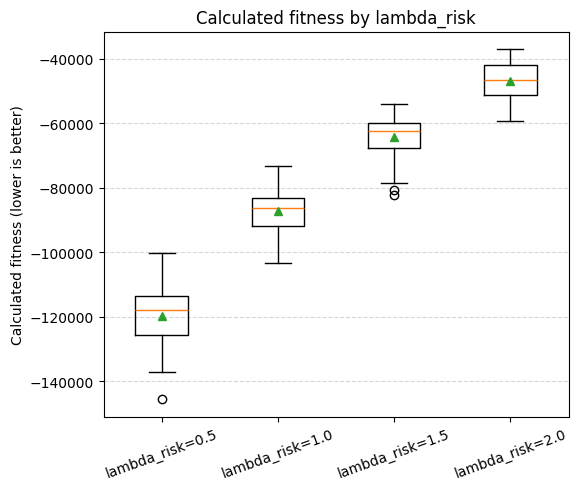

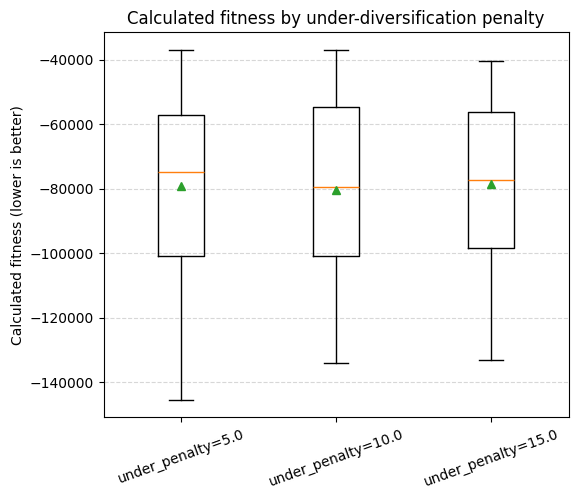

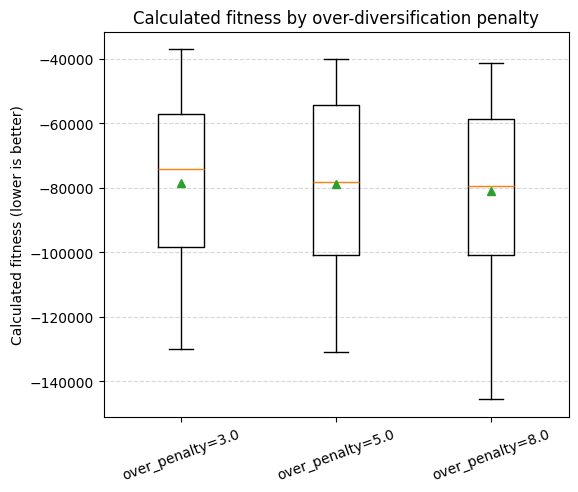

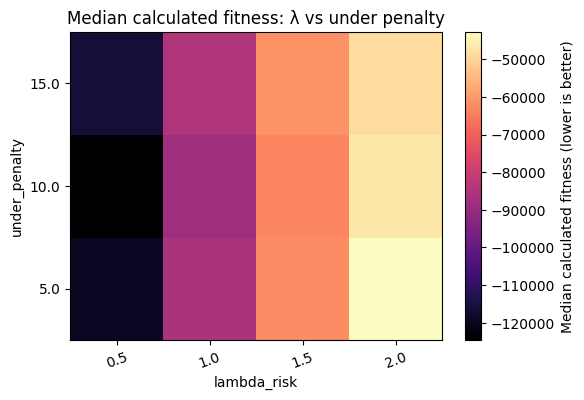

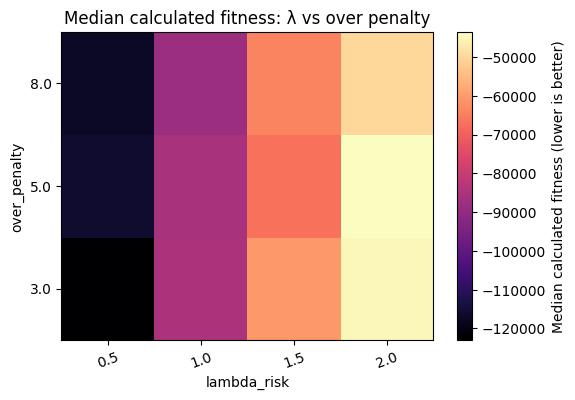

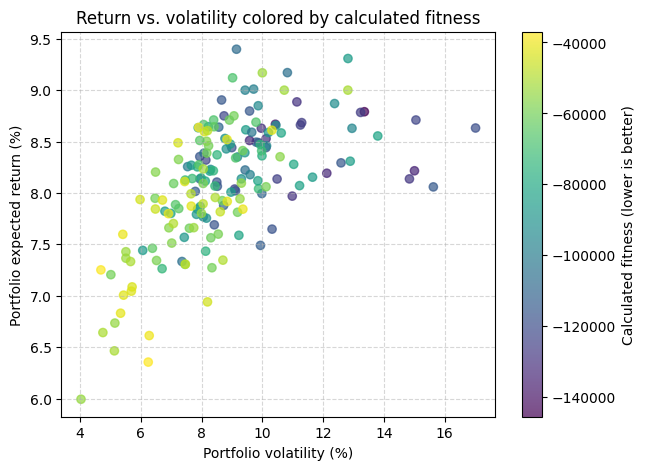

In [367]:
# ------------------------ RUN SWEEP & VISUALIZE ------------------------ #
# Tweak the grids or runs_per_setting as needed. More runs = smoother stats but longer runtime.
lambda_grid = [0.5, 1.0, 1.5, 2.0]
under_penalty_grid = [5.0, 10.0, 15.0]
over_penalty_grid = [3.0, 5.0, 8.0]
hard_penalty_grid = [1e6]  # keep hard constraints tight; add more values to explore
runs_per_setting = 5

sweep_records = run_parameter_sweep(
    lambda_grid=lambda_grid,
    under_penalty_grid=under_penalty_grid,
    over_penalty_grid=over_penalty_grid,
    hard_penalty_grid=hard_penalty_grid,
    runs_per_setting=runs_per_setting,
)

total_param_sets = len(lambda_grid) * len(under_penalty_grid) * len(over_penalty_grid) * len(hard_penalty_grid)
print(f"Completed {len(sweep_records)} runs across {total_param_sets} parameter sets.")

summary = summarize_by_params(sweep_records)
print("\nTop parameter sets by median calculated fitness (lower is better):")
for row in summary[:5]:
    print(
        f"λ={row['lambda_risk']}, under={row['under_penalty']}, over={row['over_penalty']}, hard={row['hard_penalty']}: "
        f"median_calc={row['median_calc_fitness']:.2f}, mean_calc={row['mean_calc_fitness']:.2f}, "
        f"best_calc={row['best_calc_fitness']:.2f}, runs={row['runs']}"
    )

plot_box_by_param(sweep_records, "lambda_risk", "Calculated fitness by lambda_risk")
plot_box_by_param(sweep_records, "under_penalty", "Calculated fitness by under-diversification penalty")
plot_box_by_param(sweep_records, "over_penalty", "Calculated fitness by over-diversification penalty")
plot_heatmap(sweep_records, "lambda_risk", "under_penalty", "Median calculated fitness: λ vs under penalty")
plot_heatmap(sweep_records, "lambda_risk", "over_penalty", "Median calculated fitness: λ vs over penalty")
plot_return_volatility(sweep_records)
plt.show()
